In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm


from tqdm.auto import tqdm

In [78]:
groups = pd.read_csv('groups.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')
active_studs = pd.read_csv('active_studs.csv', sep=';')

Проверяем таблицы на отсутствие значений и наличие дубликатов

In [79]:
groups

id grp
0      1206794   B
1       331024   B
2      1733498   A
3       161574   B
4       168443   B
...        ...  ..
74571  1524221   B
74572  1302888   A
74573  1778339   B
74574  1138474   A
74575  1210532   B

[74576 rows x 2 columns]

In [80]:
groups.isna().sum() #Данные на месте

id     0
grp    0
dtype: int64

In [81]:
groups.drop_duplicates() #строк столько же- дубликатов нет

id grp
0      1206794   B
1       331024   B
2      1733498   A
3       161574   B
4       168443   B
...        ...  ..
74571  1524221   B
74572  1302888   A
74573  1778339   B
74574  1138474   A
74575  1210532   B

[74576 rows x 2 columns]

In [114]:
groups.grp.value_counts() #На это моменте к системе сплитования появляются вопросы, ибо неравномерное распределение

B    59883
A    14693
Name: grp, dtype: int64

In [82]:
checks

student_id     rev
0          1627   990.0
1          3185   690.0
2         25973   690.0
3         26280   690.0
4        100300   990.0
..          ...     ...
536     5645737  1900.0
537     5651566  1900.0
538     5662322  1900.0
539     5681918  1900.0
540     5740903  1900.0

[541 rows x 2 columns]

In [83]:
checks.isna().sum() #данные на месте

student_id    0
rev           0
dtype: int64

In [84]:
checks.drop_duplicates() #Данны на месте

student_id     rev
0          1627   990.0
1          3185   690.0
2         25973   690.0
3         26280   690.0
4        100300   990.0
..          ...     ...
536     5645737  1900.0
537     5651566  1900.0
538     5662322  1900.0
539     5681918  1900.0
540     5740903  1900.0

[541 rows x 2 columns]

In [85]:
checks.describe() #смотрим распределение rev

student_id          rev
count  5.410000e+02   541.000000
mean   2.514772e+06  1059.752317
std    1.726839e+06   762.712359
min    1.627000e+03   199.000000
25%    9.871290e+05   290.000000
50%    2.526021e+06   840.000000
75%    3.993249e+06  1900.000000
max    5.740903e+06  4650.000000

In [86]:
active_studs

student_id
0         581585
1        5723133
2        3276743
3        4238589
4        4475369
...          ...
8336     1794344
8337      296883
8338     3598448
8339     3610547
8340      205705

[8341 rows x 1 columns]

In [87]:
active_studs.isna().sum() # данные на месте

student_id    0
dtype: int64

In [88]:
active_studs.drop_duplicates() #дубликатов нет

student_id
0         581585
1        5723133
2        3276743
3        4238589
4        4475369
...          ...
8336     1794344
8337      296883
8338     3598448
8339     3610547
8340      205705

[8341 rows x 1 columns]

Данные в норме, идём дальше.
Для начала сведём всё в одну таблицу.

In [89]:
groups = groups.rename(columns = {'id':'student_id'}) 

In [103]:
full = active_studs.join(groups.set_index('student_id'), on='student_id') #Собираем данные

In [104]:
full = full.join(checks.set_index('student_id'), on = 'student_id') #Собираем данные

In [110]:
full = full.fillna(0) #Заменим NaN нулями

Данные в удобной форме, можно приступать к проверке результатов теста. Начнём с проверке сплитования тех, кто зашёл в день Х.

In [117]:
full.grp.value_counts() #Есть перевес в пользу В

B    6803
A    1538
Name: grp, dtype: int64

In [121]:
A = full.query('grp == "A"')
B = full.query('grp == "B"')

Посмотрим ARPPU и визуализируем доход для понимания

In [136]:
A.query('rev != "0"').rev.mean()

933.5897435897435

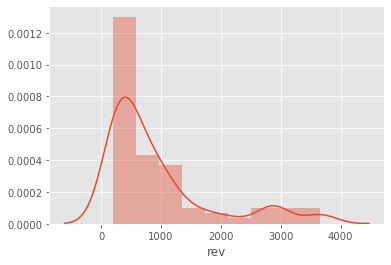

In [159]:
sns.distplot(A.query('rev != "0"').rev)

In [158]:
B.query('rev != "0"').rev.mean()

1257.8789920382171

In [160]:
sns.distplot(B.query('rev != "0"').rev)

И ARPU

In [144]:
A.rev.mean()

47.34720416124838

In [145]:
B.rev.mean()

58.05879810377777

Для сравнения средних ARPU и ARPPU воспользуемся Bootstrap'ом

In [141]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [142]:
booted_mean_ARPU = get_bootstrap_mean(A.rev, B.rev) 

In [143]:
booted_mean_ARPU["p_value"] # альфа

0.035896349845395435

Различия ARPU значимы при уровне значимости 95% 

Теперь проверим значимость различий для ARPPU

In [147]:
booted_mean_ARPPU = get_bootstrap_mean(A.query('rev != "0"').rev, B.query('rev != "0"').rev) 

In [149]:
booted_mean_ARPPU["p_value"] 

1.095366321641343e-06

В ARPPU различия так же значимы

Таким образом, мы:

1)Посмотрели главные метрики - ARPU и ARPPU.

2)В ходе исследования были обнаружены различия, которые могут быть связаны с различными факторами(неравномерность, 
непрезентативность, недостаточный размер)

3)В ходе bootstrap выяснили, что различия значимы(при уровне значимости 95%)

4)Следовательно, следует запустить новую версию на всех пользователей.